In [ ]:
!pip install -q langchain==0.1.12 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu langchain-openai

In [ ]:
!pip install pydantic==1.10.14

In [ ]:
!pip uninstall openai
!pip install -Iv  openai==0.27.8

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [5]:
os.environ['OPENAI_API_KEY'] = "sk-proj-aJ7iGMhedASGA2xOddiJT3BlbkFJc1LKfIXPWTJlHexdYO7B"

In [6]:
loader = PyPDFLoader("/content/huang2012.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='4784 IEEE TRANSACTIONS ON I NDUSTRIAL ELECTRONICS, VOL. 59, NO. 12, DECEMBER 2012\nEfﬁcient Implementation of RFID Mutual\nAuthentication Protocol\nYu-Jung Huang, Senior Member, IEEE , Wei-Cheng Lin, and Hung-Lin Li\nAbstract —Researchers have shown that the Electronic Product\nCode (EPC) Class-1 Generation-2 (C1G2) speciﬁcation has serioussecurity problems. To overcome these weaknesses, some authorshave proposed a specially designed pad generation (PadGen) func-tion to improve security. The PadGen function is used to producea cover-coding pad to mask the tag’s access password before thedata are transmitted. In this paper, we study the radio-frequencyidentiﬁcation (RFID) tag–reader mutual authentication (TRMA)scheme. Two improved authentication protocols for generating thePadGen function are described. A hardware design of these RFIDauthentication protocols conforming to the International Stan-dards Organization 18000-6 Type-C protocol, also known as EPCC1G2 RFID protocol

In [7]:
import textract
doc = textract.process("/content/huang2012.pdf")

with open('rfid.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('rfid.txt', 'r') as f:
    text = f.read()

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [8]:
type(chunks[0])

langchain_core.documents.base.Document

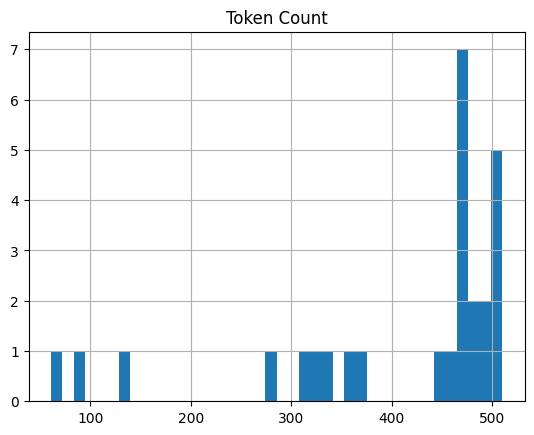

In [9]:
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]
df = pd.DataFrame({'Token Count': token_counts})
df.hist(bins=40, )
plt.show()

In [10]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(chunks, embeddings)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [11]:
query = "What is rfid?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='R ADIO-FREQUENCY IDENTIFICATION (RFID) uses a\n\nwireless system that can provide enterprises with efﬁcient\nreal-time product track-and-trace capability [1]–[3]. EPCglobal\nInc. is the leader in developing industry-driven speciﬁcations\nfor the Electronic Product Code (EPC) to support the use\nof RFID in supply chain management [4]. The International\nStandards Organization (ISO) has incorporated the EPC Class-1\nGeneration-2 (C1G2) (EPC C1G2) ultrahigh frequency (UHF)\nstandard into its ISO/IEC 18000-6 Amendment 1 as type C on\nUHF RFID for item management using devices operating in\nthe 860–960-MHz industrial–scientiﬁc–medical band [5]. The\nISO 18000-6C protocol, also known as the EPC C1G2 protocol,\nprovides only very basic security tools using a 16-b pseudoran-\ndom number generator (PRNG) and a 16-b cyclic redundancy\ncode (CRC). An authentication scheme was originally included\n\nManuscript received March 3, 2011; revised July 18, 2011 and October 7,\n201

In [12]:
chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "What is rfid?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


' RFID stands for Radio-Frequency Identification. It is a wireless system that uses radio waves to track and identify products in real-time. It is commonly used in supply chain management and is supported by industry-driven specifications such as the Electronic Product Code (EPC). However, there have been concerns about the security of RFID systems, leading to the development of authentication protocols to improve privacy and data security.'

In [13]:
from IPython.display import display
import ipywidgets as widgets

qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [14]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


HTML(value='<b>User:</b> what is rfid?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  RFID stands for Radio-Frequency Identification. It is a…

HTML(value='<b>User:</b> explain padgen')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The PadGen function is used in RFID systems to generate…

HTML(value='<b>User:</b> difference between mod and xor scheme')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The mod and xor schemes are two different methods used …